# Make grahps from data

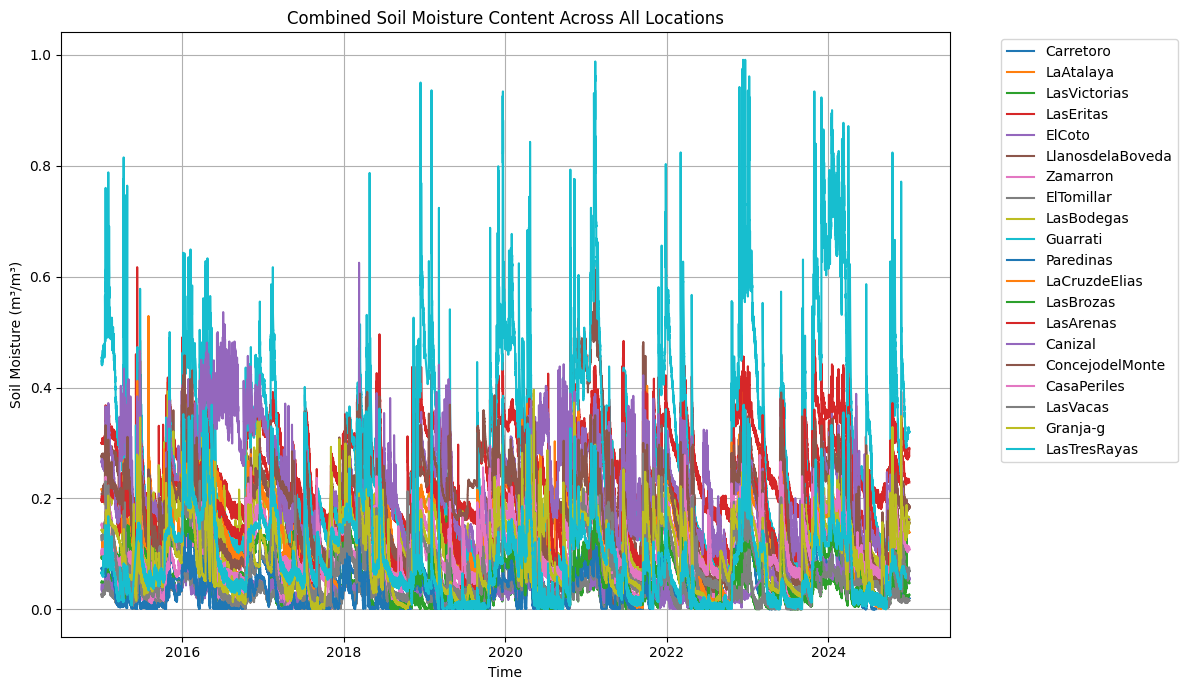

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Define directories
current_dir = os.getcwd()
rem_dir = os.path.join(current_dir, "REMEDHUS-moisture", "REMEDHUS")

# Central directory for all plots
output_dir = os.path.join(current_dir, "all_plots")
os.makedirs(output_dir, exist_ok=True)

# For combined graph data
combined_data = []

# Find all station subdirectories
locations = [f for f in os.listdir(rem_dir) if os.path.isdir(os.path.join(rem_dir, f))]

for location in locations:
    location_path = os.path.join(rem_dir, location)
    data_files = [f for f in os.listdir(location_path) if f.endswith('.stm')]
    for data_file in data_files:
        file_path = os.path.join(location_path, data_file)
        with open(file_path, 'r') as file:
            lines = file.readlines()[1:]
        times, moistures = [], []
        for line in lines:
            parts = line.split()
            if len(parts) >= 3:
                try:
                    moisture = float(parts[2])
                    if moisture <= 0 or moisture > 1:  # Adjust threshold as needed
                        continue
                    time = datetime.strptime(f"{parts[0]} {parts[1]}", "%Y/%m/%d %H:%M")
                    times.append(time)
                    moistures.append(moisture)
                except ValueError:
                    continue
        if not times:
            continue
        # Plot for each file—save in one central directory!
        plt.figure(figsize=(10, 6))
        plt.plot(times, moistures, label=f'{location} - {data_file}')
        plt.title(f"Soil Moisture: {location} - {data_file}")
        plt.xlabel("Time")
        plt.ylabel("Soil Moisture (m³/m³)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        # Save to central folder only
        base_label = f"{location}_{os.path.splitext(data_file)[0]}"
        plt.savefig(os.path.join(output_dir, f"{base_label}_plot.png"))
        plt.close()
        combined_data.append((location, times, moistures))

# Combined plot for all locations—save in the same folder
plt.figure(figsize=(12, 7))
for location, times, moistures in combined_data:
    plt.plot(times, moistures, label=location)
plt.title("Combined Soil Moisture Content Across All Locations")
plt.xlabel("Time")
plt.ylabel("Soil Moisture (m³/m³)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "combined_moisture_plot.png"))
plt.show()
plt.close()

# Asses similarities

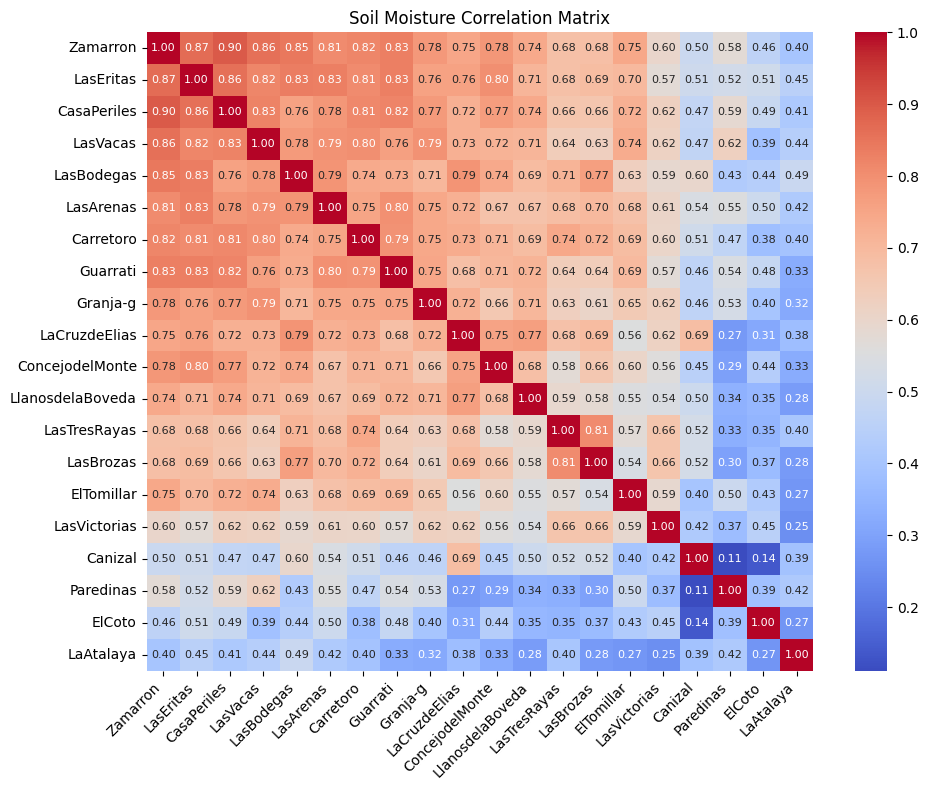

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pandas as pd

# Define directories
current_dir = os.getcwd()
rem_dir = os.path.join(current_dir, "REMEDHUS-moisture", "REMEDHUS")
output_dir = os.path.join(current_dir, "all_plots")
os.makedirs(output_dir, exist_ok=True)

# Gather all data for dataframe
location_data = {}
all_times = set()

locations = [f for f in os.listdir(rem_dir) if os.path.isdir(os.path.join(rem_dir, f))]

for location in locations:
    location_path = os.path.join(rem_dir, location)
    data_files = [f for f in os.listdir(location_path) if f.endswith('.stm')]
    for data_file in data_files:
        file_path = os.path.join(location_path, data_file)
        with open(file_path, 'r') as file:
            lines = file.readlines()[1:]
        times, moistures = [], []
        for line in lines:
            parts = line.split()
            if len(parts) >= 3:
                try:
                    moisture = float(parts[2])
                    if moisture <= 0 or moisture > 1:
                        continue
                    time = datetime.strptime(f"{parts[0]} {parts[1]}", "%Y/%m/%d %H:%M")
                    times.append(time)
                    moistures.append(moisture)
                    all_times.add(time)
                except ValueError:
                    continue
        if times:
            if location not in location_data:
                location_data[location] = pd.Series(moistures, index=times)
            else:
                # If duplicate, take mean for overlapping times
                previous = location_data[location]
                combined = pd.concat([previous, pd.Series(moistures, index=times)], axis=1)
                location_data[location] = combined.mean(axis=1)

# Create DataFrame aligning all timestamps
all_times_sorted = sorted(all_times)
df = pd.DataFrame({k: v.reindex(all_times_sorted).interpolate() for k, v in location_data.items()}, index=all_times_sorted)

# Compute correlation matrix
corr_matrix = df.corr()

# Save to CSV for easy viewing
# corr_matrix.to_csv(os.path.join(output_dir, "correlation_matrix.csv"))

# Display as a heatmap
import seaborn as sns

# Number of locations in reduced plot
N = 20  # Change as desired

# Get mean correlation for each location and select top N
mean_corr = corr_matrix.mean().sort_values(ascending=False)
top_locations = mean_corr.head(N).index

# Subset the correlation matrix
subset_matrix = corr_matrix.loc[top_locations, top_locations]

plt.figure(figsize=(10,8))
sns.heatmap(subset_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            annot_kws={"size": 8})
plt.title("Soil Moisture Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "correlation_matrix_heatmap_top.png"))
plt.show()
plt.close()
